:::{markdown}
## 1. Data Loading and Initial Exploration

This section loads the processed dataset containing GPCR plasma membrane expression (PME) scores and a curated set of biologically relevant features. All the features used for model training and analysis are extracted here.
:::

In [1]:
# Import necessary libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
import shap

# Set working directory
os.chdir('/home/goel107/GPCRs/GPCR_ML_2-NEW/')

# Load dataset
df_gpcr = pd.read_csv('GPCR_TRANSCRIPT_PROTEIN_FEATURES.csv')

# Define the list of specific features to extract
selected_features = [
    'compound_name', 'GPCR_PME', 'relative_tmd_1', 'relative_tmd_2', 'relative_tmd_3', 'relative_tmd_4', 'relative_tmd_5', 'relative_tmd_6', 'relative_tmd_7',
    'relative_N_terminal_loop_length', 'relative_downstream_loop_length_1', 'relative_upstream_loop_length_1',
    'relative_downstream_loop_length_2', 'relative_upstream_loop_length_2', 'relative_downstream_loop_length_3',
    'relative_upstream_loop_length_3', 'relative_C_terminal_loop_length', 'Molecular_Weight', 'Isoelectric_Point', 'Aromaticity', 'instability_index', 'gravy',
    'sasa_total', 'sasa_crg', 'sasa_plr', 'sasa_aplr', 'f_crg', 'f_plr', 'f_aplr', 'alpha_helix', '3_10_helix', 'extended_configuration', 
    'isolated_beta_bridge', 'turn', 'coil', 'adjusted_tmd_delta_G_1', 'adjusted_tmd_delta_G_2', 'adjusted_tmd_delta_G_3', 'adjusted_tmd_delta_G_4',
    'adjusted_tmd_delta_G_5', 'adjusted_tmd_delta_G_6', 'adjusted_tmd_delta_G_7',
    'CAI', 'Nc', 'GC3s', 'CpG_frame1_2', 'avgCU', 'CPS_sum', 'CPSpL', 'Global_tAI', 'tAI10Min', 'tAI10Max', 'tAI10q25.25.',
    'tAI10q75.75.', 'avgCU_first20', 'avgCU_first10', 'avgCU_first5', 'GC', 'GC10min', 'GC10q25', 'GC10q75', 'GC10max',
    'X40deltaG', 'X40freqens', 'plus10valRNAss', 'zeroto38avgRNAss', 'zeroto38minRNAss', 'zeroto38q25RNAss', 
    'zeroto38q75RNAss', 'zeroto38maxRNAss', 'deltaG', 'freqens', 'avgRNAss', 'minRNAss', 'q25RNAss', 'q75RNAss', 'maxRNAss'
]

# Create new dataframe with selected features
df_selected = df_gpcr[selected_features]

# Extract features for initial exploration
df_features_raw = df_selected.iloc[:, 2:]

# Check for NaNs
nan_summary = df_features_raw.isna().sum()
print("NaN summary per feature:")
print(nan_summary[nan_summary > 0])  # Only show features with NaNs

# Impute NaNs with median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df_features_raw = pd.DataFrame(imputer.fit_transform(df_features_raw), columns=df_features_raw.columns)

# Verify no NaNs left
print(f"NaNs after imputation: {df_features_raw.isna().sum().sum()}")

print(f"Dataset shape: {df_selected.shape}")
print(f"PME range: {df_selected['GPCR_PME'].min():.2f} - {df_selected['GPCR_PME'].max():.2f}")

NaN summary per feature:
plus10valRNAss      1
zeroto38avgRNAss    1
zeroto38minRNAss    1
zeroto38q25RNAss    1
zeroto38q75RNAss    1
zeroto38maxRNAss    1
avgRNAss            1
minRNAss            1
q25RNAss            1
q75RNAss            1
maxRNAss            1
dtype: int64
NaNs after imputation: 0
Dataset shape: (780, 77)
PME range: 82.90 - 6534.16


/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


:::{markdown}
## 2. PME Distribution Analysis for Cutoff Selection

This section analyzes the distribution of GPCR plasma membrane expression (PME) values to guide the selection of a threshold for binary classification (high vs low PME). Various percentiles, descriptive statistics, and visual tools (histograms, KDE plots, CDF) are used to determine a biologically reasonable and data-driven cutoff — ultimately guiding supervised classification downstream.
:::

PME Distribution Statistics:
Mean: 1627.59
Median: 862.81
Standard Deviation: 2034.26
IQR: 1123.08

Potential Reference Points for Manual Cutoff Selection:

Percentiles:
  10th: 133.68
  25th: 282.17
  33rd: 479.42
  median: 862.81
  67th: 1044.01
  75th: 1405.24

Outlier Boundaries:
  lower_fence: -1402.45
  upper_fence: 3089.86

📊 Class Distribution Preview for Common Cutoffs:
25th percentile (282): 195 low (25.0%) vs 585 high (75.0%)
33rd percentile (479): 258 low (33.1%) vs 522 high (66.9%)
Median (863): 390 low (50.0%) vs 390 high (50.0%)
67th percentile (1044): 522 low (66.9%) vs 258 high (33.1%)
75th percentile (1405): 585 low (75.0%) vs 195 high (25.0%)

🎯 Manual PME Cutoff Selected: 2644

📊 Class Distribution with Manual Cutoff:
Low PME (< 2644): 626 samples – Class 0
High PME (≥ 2644): 154 samples – Class 1
Class imbalance ratio: 0.25:1


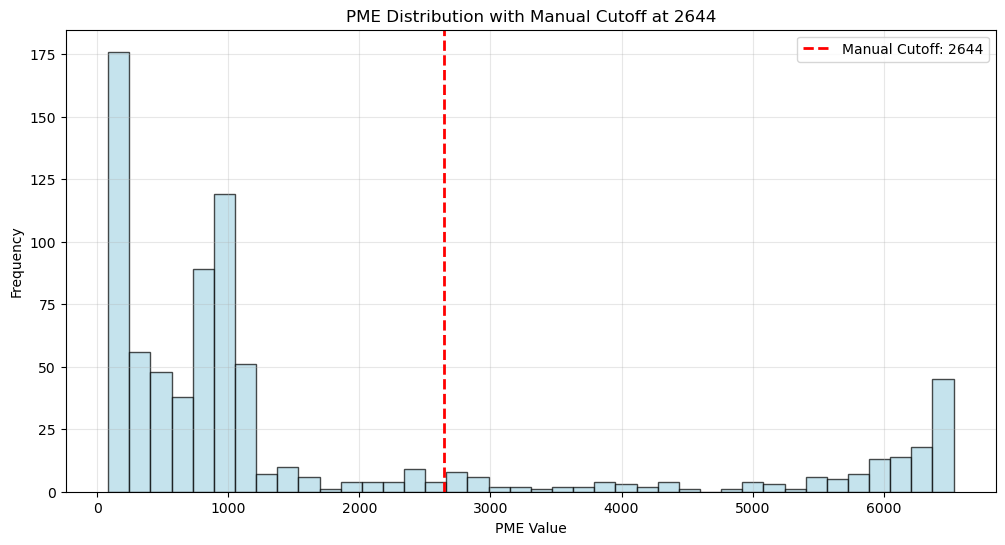

✅ Cutoff appears reasonable for binary classification.


In [2]:
# PME Distribution Visualization for Manual Cutoff Decision
pme = df_selected['GPCR_PME']

# Calculate comprehensive statistical summary
stats_summary = pme.describe(percentiles=[0.05, 0.10, 0.25, 0.33, 0.50, 0.67, 0.75, 0.90, 0.95])
iqr = stats_summary['75%'] - stats_summary['25%']

print("PME Distribution Statistics:")
print(f"Mean: {stats_summary['mean']:.2f}")
print(f"Median: {stats_summary['50%']:.2f}")
print(f"Standard Deviation: {stats_summary['std']:.2f}")
print(f"IQR: {iqr:.2f}")

# Potential threshold reference points
threshold_references = {
    'percentiles': {
        '10th': stats_summary['10%'],
        '25th': stats_summary['25%'],
        '33rd': stats_summary['33%'],
        'median': stats_summary['50%'],
        '67th': stats_summary['67%'],
        '75th': stats_summary['75%']
    },
    'outlier_boundaries': {
        'lower_fence': stats_summary['25%'] - 1.5*iqr,
        'upper_fence': stats_summary['75%'] + 1.5*iqr
    }
}

print("\nPotential Reference Points for Manual Cutoff Selection:")
for method, values in threshold_references.items():
    print(f"\n{method.replace('_', ' ').title()}:")
    for k, v in values.items():
        print(f"  {k}: {v:.2f}")

print(f"\n📊 Class Distribution Preview for Common Cutoffs:")
common_cutoffs = [stats_summary['25%'], stats_summary['33%'], stats_summary['50%'], stats_summary['67%'], stats_summary['75%']]
cutoff_names = ['25th percentile', '33rd percentile', 'Median', '67th percentile', '75th percentile']

for cutoff, name in zip(common_cutoffs, cutoff_names):
    low_count = np.sum(pme < cutoff)
    high_count = len(pme) - low_count
    low_pct = (low_count / len(pme)) * 100
    print(f"{name} ({cutoff:.0f}): {low_count} low ({low_pct:.1f}%) vs {high_count} high ({100-low_pct:.1f}%)")

# MANUAL PME CUTOFF SECTION

# Manual PME Cutoff Definition
# Replace this value with your chosen cutoff based on biological knowledge
MANUAL_PME_CUTOFF = 2644  # Example: Change this to your desired cutoff

print(f"\n🎯 Manual PME Cutoff Selected: {MANUAL_PME_CUTOFF}")

# Create binary labels using manual cutoff
y = (df_selected['GPCR_PME'] >= MANUAL_PME_CUTOFF).astype(int)

# Display class distribution
high_pme_count = np.sum(y)
low_pme_count = len(y) - high_pme_count
low_pme_pct = (low_pme_count / len(y)) * 100

print(f"\n📊 Class Distribution with Manual Cutoff:")
print(f"Low PME (< {MANUAL_PME_CUTOFF}): {low_pme_count} samples – Class 0")
print(f"High PME (≥ {MANUAL_PME_CUTOFF}): {high_pme_count} samples – Class 1")

# Calculate class imbalance ratio
imbalance_ratio = high_pme_count / max(low_pme_count, 1)  # Avoid division by zero
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")

# Visualize the cutoff on PME distribution
plt.figure(figsize=(12, 6))
plt.hist(df_selected['GPCR_PME'], bins=40, alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(MANUAL_PME_CUTOFF, color='red', linestyle='--', linewidth=2, 
           label=f'Manual Cutoff: {MANUAL_PME_CUTOFF}')
plt.xlabel('PME Value')
plt.ylabel('Frequency')
plt.title(f'PME Distribution with Manual Cutoff at {MANUAL_PME_CUTOFF}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Validate cutoff reasonableness
if MANUAL_PME_CUTOFF > df_selected['GPCR_PME'].max():
    print("⚠️  WARNING: Cutoff exceeds maximum PME value in dataset!")
elif MANUAL_PME_CUTOFF < df_selected['GPCR_PME'].min():
    print("⚠️  WARNING: Cutoff is below minimum PME value in dataset!")
elif low_pme_pct < 5 or low_pme_pct > 95:
    print("⚠️  WARNING: Extreme class imbalance detected. Consider adjusting cutoff.")
else:
    print("✅ Cutoff appears reasonable for binary classification.")

✅ Data split completed:
✅ Feature scaling completed (no data leakage)
Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Best params: {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
✅ Random Forest model trained

📊 Model Performance:
Balanced Accuracy: 0.771
Precision:         0.512
Recall:            0.710
F1-Score:          0.595
ROC-AUC:           0.882

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       125
           1       0.51      0.71      0.59        31

    accuracy                           0.81       156
   macro avg       0.72      0.77      0.73       156
weighted avg       0.84      0.81      0.82       156


📊 Confusion Matrix:
TP: 22, FP: 21, TN: 104, FN: 9
True Positive Rate (Recall): 0.710
False Positive Rate: 0.168

🔍 Computing SHAP values...


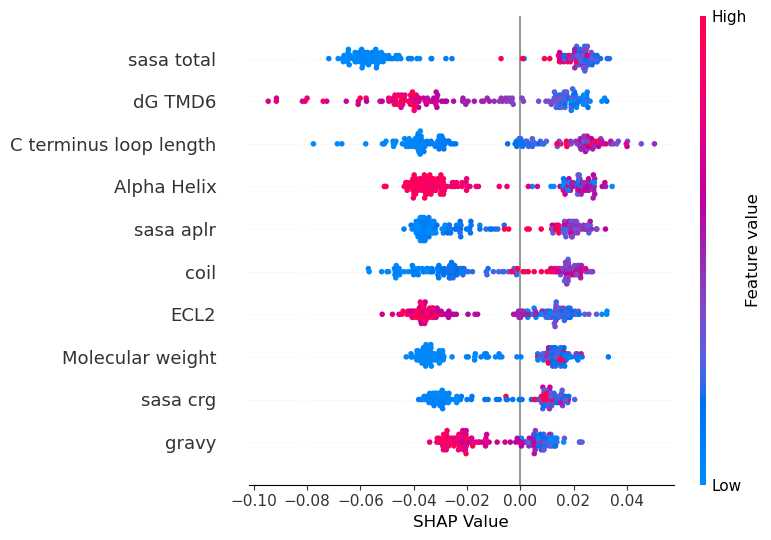


🌲 Random Forest Gini-based Feature Importances:
                          Feature  Gini Importance
                       sasa total         0.057464
                             coil         0.042640
           C terminus loop length         0.042192
                        sasa aplr         0.040215
                 Molecular weight         0.039582
                      Alpha Helix         0.037460
                             ECL2         0.036839
                          dG TMD6         0.036072
                         sasa crg         0.031932
                            gravy         0.027004
             isolated beta bridge         0.025804
                   relative_tmd_3         0.021238
                      Length TMD5         0.018666
           N terminus loop length         0.016559
                       3_10_helix         0.016479
                   relative_tmd_1         0.015935
           adjusted_tmd_delta_G_4         0.015170
                             turn

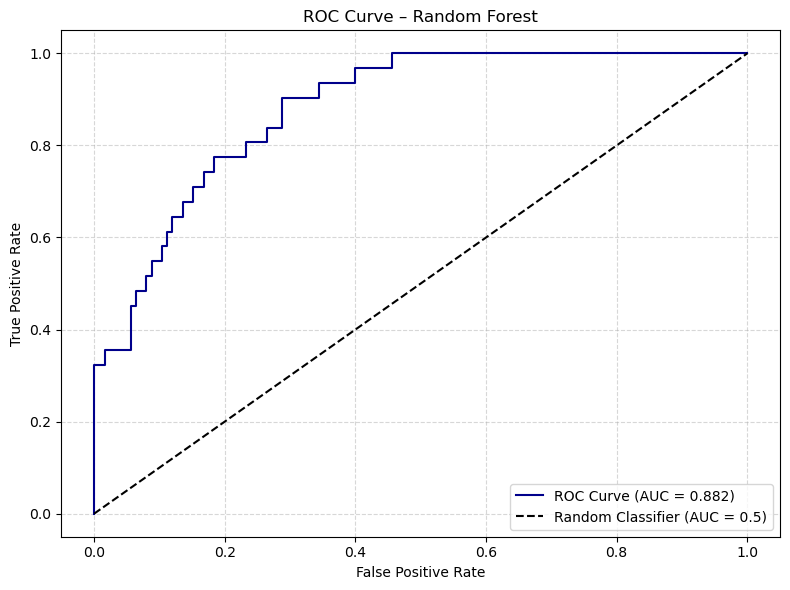

In [3]:
# SMOTE + GridSearchCV hyperparameter tuning
X_train, X_test, y_train, y_test = train_test_split(
    df_features_raw,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print(f"✅ Data split completed:")

X_train_scaled = X_train.values
X_test_scaled  = X_test.values
print(f"✅ Feature scaling completed (no data leakage)")

# ✅ Use SMOTE inside a pipeline to avoid data leakage
rf = RandomForestClassifier(random_state=42)
smote_rf_pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("rf", rf)
])

param_grid = {
    'rf__n_estimators': [200, 300, 400],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__class_weight': ['balanced']
}

gs = GridSearchCV(
    smote_rf_pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # ✅ reproducible CV
    n_jobs=-1,
    verbose=1
)
gs.fit(X_train_scaled, y_train)
print(f"✅ Best params: {gs.best_params_}")

rf_model = gs.best_estimator_
print(f"✅ Random Forest model trained")

y_pred  = rf_model.predict(X_test_scaled)
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

bal_accuracy = balanced_accuracy_score(y_test, y_pred)
precision    = precision_score(y_test, y_pred)
recall       = recall_score(y_test, y_pred)
f1           = f1_score(y_test, y_pred)
roc_auc      = roc_auc_score(y_test, y_proba)

print(f"\n📊 Model Performance:")
print(f"Balanced Accuracy: {bal_accuracy:.3f}")
print(f"Precision:         {precision:.3f}")
print(f"Recall:            {recall:.3f}")
print(f"F1-Score:          {f1:.3f}")
print(f"ROC-AUC:           {roc_auc:.3f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Confusion Matrix:")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"True Positive Rate (Recall): {tp / (tp + fn):.3f}")
print(f"False Positive Rate: {fp / (fp + tn):.3f}")

print(f"\n🔍 Computing SHAP values...")
np.random.seed(42)
explainer    = shap.TreeExplainer(rf_model.named_steps['rf'])
shap_values  = explainer.shap_values(X_test_scaled)
if isinstance(shap_values, list):
    shap_class_values = shap_values[1]
elif shap_values.ndim == 3:
    shap_class_values = shap_values[:, :, 1]
else:
    shap_class_values = shap_values
 
# Map original feature names to publication labels
rename_map = {
    'sasa_total': 'sasa total',
    'sasa_crg': 'sasa crg',
    'sasa_aplr': 'sasa aplr',
    'isolated_beta_bridge': 'isolated beta bridge',
    'adjusted_tmd_delta_G_6': 'dG TMD6',
    'alpha_helix': 'Alpha Helix',
    'Molecular_Weight': 'Molecular weight',
    'relative_upstream_loop_length_2': 'ECL2',
    'relative_C_terminal_loop_length': 'C terminus loop length',
    'relative_N_terminal_loop_length': 'N terminus loop length',
    'relative_upstream_loop_length_3': 'Upstream loop length 3',
    'relative_upstream_loop_length_1': 'Upstream loop length 1',
    'relative_tmd_5': 'Length TMD5',
    'adjusted_tmd_delta_G_2': 'dG TMD2',
}    

# Prepare display names for SHAP plot - use actual feature names from df_features_raw
feature_names_list = list(df_features_raw.columns)
display_names = [rename_map.get(f, f) for f in feature_names_list]

# SHAP Summary Plot (top 10 features)
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_class_values,
    X_test_scaled,
    feature_names=display_names,
    plot_type='dot',
    max_display=10,
    show=False
)

plt.xlabel('SHAP Value', fontsize=12)
plt.tight_layout()

# Save as high-resolution PDF
plt.savefig('SHAP-allGFP_all_features4.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# 🌲 Gini-based Feature Importance
print("\n🌲 Random Forest Gini-based Feature Importances:")

# Access the trained Random Forest inside the pipeline
trained_rf = rf_model.named_steps['rf']
importances = trained_rf.feature_importances_

# Use display_names for feature names (already mapped earlier)
feature_names = display_names

# Create and display sorted DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini Importance': importances
}).sort_values(by='Gini Importance', ascending=False)

print(importance_df.to_string(index=False))

# 🔍 Enhanced ROC Data Export for Origin Plotting
print(f"\n📈 Generating comprehensive ROC data for Origin plotting...")

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Create comprehensive ROC DataFrame for export
roc_df = pd.DataFrame({
    'False_Positive_Rate': fpr,
    'True_Positive_Rate': tpr,
    'Threshold': thresholds,
    'Specificity': 1 - fpr,  # 1 - FPR
    'Sensitivity': tpr,      # Same as TPR
    'Point_Index': range(len(fpr))
})

# Add additional calculated metrics
roc_df['Youden_J'] = roc_df['True_Positive_Rate'] + roc_df['Specificity'] - 1
roc_df['Distance_to_Perfect'] = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Display ROC data summary
print(f"✅ ROC Data Generated:")
print(f"  Total data points: {len(roc_df)}")
print(f"  AUC Score: {roc_auc:.6f}")
print(f"  FPR range: {fpr.min():.6f} to {fpr.max():.6f}")
print(f"  TPR range: {tpr.min():.6f} to {tpr.max():.6f}")
print(f"  Threshold range: {thresholds.min():.6f} to {thresholds.max():.6f}")

# Optional: Print all data in copy-pasteable format
print(f"\n📋 Complete ROC Data (Copy-Paste Ready for Origin):")
print("# GPCR PME ROC Curve Data")
print("# False_Positive_Rate\tTrue_Positive_Rate\tThreshold\tSpecificity\tSensitivity\tPoint_Index\tYouden_J\tDistance_to_Perfect")

for idx, row in roc_df.iterrows():
    print(f"{row['False_Positive_Rate']:.8f}\t{row['True_Positive_Rate']:.8f}\t{row['Threshold']:.8f}\t{row['Specificity']:.8f}\t{row['Sensitivity']:.8f}\t{row['Point_Index']}\t{row['Youden_J']:.8f}\t{row['Distance_to_Perfect']:.8f}")

# 🧪 Visual ROC Curve for Smoothness Check
plt.figure(figsize=(8, 6))
plt.plot(roc_df['False_Positive_Rate'], roc_df['True_Positive_Rate'], label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [4]:
# Comprehensive Model Comparison
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Use raw training data (no scaling) to match Random Forest approach
X_comparison = X_train.values       # Raw feature matrix
y_comparison = y_train              # Corresponding labels

print(f"🔍 Comparing models using {X_comparison.shape[0]} training samples...")

# Define classifiers for comparison
classifiers = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced', max_iter=1_000)),
    ('k-NN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(class_weight='balanced', random_state=42)),
    ('Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('SVM Linear', SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)),
    ('SVM RBF', SVC(class_weight='balanced', probability=True, random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Neural Network', MLPClassifier(max_iter=1_000, random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Define evaluation metrics
metrics = {
    'balanced_accuracy':   'balanced_accuracy',
    'f1':        'f1',
    'precision': 'precision',
    'recall':    'recall',
    'roc_auc':   'roc_auc'
}

results = []

for name, clf in classifiers:
    print(f"  Evaluating {name}...")
    cv_results = cross_validate(
        clf,
        X_comparison,
        y_comparison,
        cv=5,
        scoring=metrics,
        n_jobs=-1,
        return_train_score=False
    )
    # Store mean performance across folds
    metrics_dict = {'Classifier': name}
    for metric in metrics:
        metrics_dict[metric.capitalize()] = np.mean(cv_results[f'test_{metric}'])
    results.append(metrics_dict)

# Compile and sort results
results_df = (
    pd.DataFrame(results)
      .sort_values('Recall', ascending=False)      # Prioritize sensitivity
      .reset_index(drop=True)
)

print("\n✅ Cross-Validation Results (5-fold):")
print(results_df.to_string(index=False, float_format='%.3f'))

# Highlight top performers
print("\n🎯 Top 3 Models by Recall (Critical for PME Detection):")
for _, row in results_df.head(3).iterrows():
    print(f"  {row['Classifier']}: {row['Recall']:.3f}")

print("\n✅ Model comparison completed")

🔍 Comparing models using 624 training samples...
  Evaluating Logistic Regression...
  Evaluating k-NN...
  Evaluating Decision Tree...


/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

  Evaluating Random Forest...
  Evaluating SVM Linear...
  Evaluating SVM RBF...
  Evaluating Naive Bayes...
  Evaluating Gradient Boosting...
  Evaluating Neural Network...
  Evaluating XGBoost...


/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/goel107/.conda/envs/GPCR_Machine_learning/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:32:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/hom


✅ Cross-Validation Results (5-fold):
         Classifier  Balanced_accuracy    F1  Precision  Recall  Roc_auc
         SVM Linear              0.731 0.505      0.371   0.790    0.744
            SVM RBF              0.690 0.467      0.347   0.716    0.763
Logistic Regression              0.676 0.454      0.347   0.658    0.746
        Naive Bayes              0.592 0.350      0.336   0.366    0.770
      Decision Tree              0.590 0.343      0.380   0.316    0.590
            XGBoost              0.595 0.330      0.470   0.276    0.796
  Gradient Boosting              0.587 0.315      0.495   0.244    0.799
               k-NN              0.563 0.269      0.382   0.211    0.727
     Neural Network              0.522 0.179      0.337   0.188    0.567
      Random Forest              0.544 0.173      0.492   0.113    0.813

🎯 Top 3 Models by Recall (Critical for PME Detection):
  SVM Linear: 0.790
  SVM RBF: 0.716
  Logistic Regression: 0.658

✅ Model comparison completed
